In [53]:
from teddy.data.dataset import MsaLabels
from teddy.lightning.datamodule import BDS_datamodule
import teddy.data.Alphabet as alphabet
from copy import deepcopy

import torch
from torch.optim import Adam
import gc

from sbi.analysis import pairplot
import matplotlib.pyplot as plt

from sbi.neural_nets.net_builders import build_nsf
from sbi.neural_nets.embedding_nets import CausalCNNEmbedding
import numpy as np


alphabet_instance = alphabet.Alphabet(list( "ATGCX-"))

train_ratio = 0.8
batch_size = 1
val_batch_size = batch_size

# Optimize dataloader performance
num_workers = 2  # Parallel data loading workers

#msa = MsaLabels(dir = "data/example/seq", alphabet=alphabet_instance, limit_size=200)
data = BDS_datamodule(data_dir = "data/example/seq", 
                      alphabet=alphabet_instance, 
                      limit_size=200,
                      max_sites_len=200,
                      train_ratio=train_ratio, 
                      val_batch_size=val_batch_size, 
                      batch_size=batch_size,
                      num_workers=num_workers,
                      prefetch_factor=1,
                      persistent_workers=False, 
                      pin_memory=False, 
                      cache_dir = "data/cache")

data.setup()


# Setting up dataloaders

In [ ]:
# Density estimator with first sequence and prior just for the dimensionality
torch.manual_seed(0)

# Define training params
learning_rate = 5e-4
validation_fraction = 0.1  # 10% of the data will be used for validation
stop_after_epochs = 20  # Stop training after 20 epochs with no improvement
max_num_epochs = 2**31 - 1

train_loader = data.train_dataloader()
val_loader = data.val_dataloader()

train_iter = iter(train_loader)
batch = next(train_iter)

x_batch = batch[0][0]
theta_batch = batch[1]

embedding_net = CausalCNNEmbedding(  # SOLUTION
    input_shape=(batch[0][0].shape[1],),      # 20000 timepoints
    in_channels=1,            # 1 channel: sequence data
    output_dim=20,            # Compress to 20 learned summary features
    num_conv_layers=5,        # Number of dilated causal conv layers
    kernel_size=2,            # Kernel size for convolutions
)

density_estimator = build_nsf(theta_batch, x_batch, z_score_x="none", z_score_y="none", embedding_net=embedding_net) # theta batch dimension, x batch dimension

Batch size: 2
Batch x shape: torch.Size([1, 20402]), Batch theta shape: torch.Size([1, 2])
x_batch[0].shape: torch.Size([1, 20402])
theta_batch[0].shape: torch.Size([2])
(16, 127)
(64, 63)
(20, 31)


# Training Loop 

In [56]:
optimizer = Adam(list(density_estimator.parameters()), lr=learning_rate)

# Clean up initialization batch
# del train_iter, batch, x_batch, theta_batch
gc.collect()

# === OPTIMIZED TRAINING LOOP ===
epoch = 0
best_val_loss = float("Inf")
epochs_since_last_improvement = 0
converged = False

print("Starting training with memory optimization...")

while epoch <= max_num_epochs and not converged:
    # === TRAINING PHASE ===
    density_estimator.train()
    train_loss_sum = 0
    num_train_samples = 0
    
    for batch_idx, batch in enumerate(train_loader):
        # Convert batch data to tensors
        # x_batch = batch[0][0].squeeze()
        # theta_batch = torch.as_tensor(batch[1], dtype=torch.float32).squeeze()
        x_batch = batch[0][0]
        theta_batch = batch[1]

        #print(f"Training Batch {batch_idx}: x shape {x_batch.shape}, theta shape {theta_batch.shape}")

        # Forward pass and loss computation
        optimizer.zero_grad()
        train_losses = density_estimator.loss(theta_batch, x_batch)
        train_loss = torch.mean(train_losses)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss_sum += train_losses.sum().item()
        num_train_samples += theta_batch.size(0)
        
        # CRITICAL: Immediate cleanup after each batch
        del x_batch, theta_batch, train_losses, train_loss
        
        # Periodic garbage collection during training
        if batch_idx % 10 == 0:
            gc.collect()

    epoch += 1
    train_loss_average = train_loss_sum / num_train_samples

    # === VALIDATION PHASE ===
    density_estimator.eval()
    val_loss_sum = 0
    num_val_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            x_batch = batch[0][0]
            theta_batch = batch[1]
            
            val_losses = density_estimator.loss(theta_batch, x_batch)
            val_loss_sum += val_losses.sum().item()
            num_val_samples += theta_batch.size(0)
            
            # Immediate cleanup
            del x_batch, theta_batch, val_losses
            
            if batch_idx % 5 == 0:
                gc.collect()
    
    val_loss = val_loss_sum / num_val_samples

    # === MODEL CHECKPOINTING ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_since_last_improvement = 0
        # Store only state dict, not entire model
        best_model_state_dict = deepcopy(density_estimator.state_dict())
    else:
        epochs_since_last_improvement += 1

    # === CONVERGENCE CHECK ===
    if epochs_since_last_improvement > stop_after_epochs - 1:
        density_estimator.load_state_dict(best_model_state_dict)
        converged = True
        print(f'\nNeural network successfully converged after {epoch} epochs')
    else:
        print(f"Epoch {epoch}: Train loss: {train_loss_average:.4f}, Val loss: {val_loss:.4f}")
    
    # Force garbage collection after each epoch
    gc.collect()

# === POST-TRAINING CLEANUP ===
print("\nCleaning up training resources...")

# Delete dataloaders to free worker memory
del val_loader
gc.collect()

# Optional: If using CUDA, clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Training complete and memory cleaned!")

Starting training with memory optimization...
Epoch 1: Train loss: 15.6266, Val loss: 13.8448
Epoch 2: Train loss: 12.3514, Val loss: 11.4705
Epoch 3: Train loss: 10.1580, Val loss: 9.7293
Epoch 4: Train loss: 8.7177, Val loss: 8.3016
Epoch 5: Train loss: 7.5009, Val loss: 7.6395
Epoch 6: Train loss: 6.7134, Val loss: 6.6907
Epoch 7: Train loss: 6.3302, Val loss: 6.2800
Epoch 8: Train loss: 5.8440, Val loss: 5.6683
Epoch 9: Train loss: 5.4995, Val loss: 5.7648
Epoch 10: Train loss: 5.3244, Val loss: 5.0921
Epoch 11: Train loss: 4.8698, Val loss: 5.0811
Epoch 12: Train loss: 4.7160, Val loss: 5.9379
Epoch 13: Train loss: 4.5833, Val loss: 4.8047
Epoch 14: Train loss: 4.2717, Val loss: 4.3253
Epoch 15: Train loss: 4.1590, Val loss: 4.2580
Epoch 16: Train loss: 4.1752, Val loss: 4.1913
Epoch 17: Train loss: 4.1529, Val loss: 4.1389
Epoch 18: Train loss: 3.9593, Val loss: 4.1842
Epoch 19: Train loss: 3.8510, Val loss: 4.0761
Epoch 20: Train loss: 3.8553, Val loss: 4.2192
Epoch 21: Train lo

In [57]:
train_iter = iter(train_loader)
batch = next(train_iter)

x_o = torch.flatten(torch.as_tensor(batch[0][0], dtype=torch.float32), start_dim=1)
theta_o = torch.as_tensor(batch[1], dtype=torch.float32)

print(f"Shape of x_o: {x_o.shape}            # Must have a batch dimension")

samples = density_estimator.sample((1000,), condition=x_o).detach()
print(
    f"Shape of samples: {samples.shape}  # Samples are returned with a batch dimension."
)

samples = samples.squeeze(dim=1)
print(f"Shape of samples: {samples.shape}     # Removed batch dimension.")

Shape of x_o: torch.Size([1, 20402])            # Must have a batch dimension
Shape of samples: torch.Size([1000, 1, 2])  # Samples are returned with a batch dimension.
Shape of samples: torch.Size([1000, 2])     # Removed batch dimension.


/home/filippo/Documents/temp_folder/sbi-hackathon-2026/tmp_pip/ipykernel_475883/3364581729.py:4: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


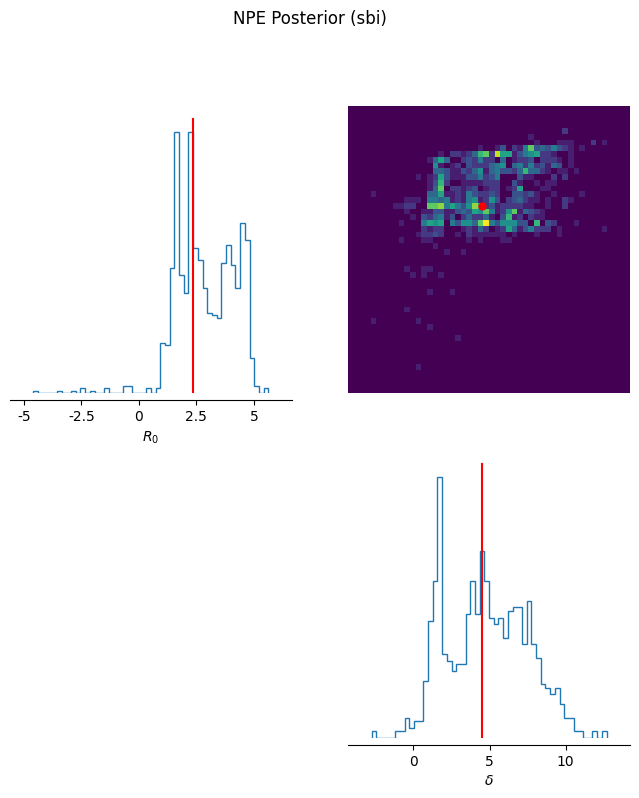

In [58]:
# Visualize posterior with pairplot
param_labels = [r"$R_0$", r"$\delta$"]

fig, axes = pairplot(
    samples,
    #limits=[[0.05, 0.15], [0.01, 0.03], [0.005, 0.03], [0.005, 0.15]],
    labels=param_labels,
    figsize=(8, 8),
    points=theta_o,  # True parameters
    points_colors="r",
)
plt.suptitle("NPE Posterior (sbi)", y=1.02)
plt.show()